# Exogenous Uniswap Process modeling 


## Liquidity demand stochastic process

1. Acquire time series of order book for single collateral DAI 2017-2019; this is the proxy for the liquidity demand of RAI
2. Fit a parametric distribution to the data, resulting in a distribution $F^D_{RAI}(t;\mu_{RAI})$ and fitted parameters $\mu_{RAI}$.


To obtain this data, we ran a [Uniswap cadCAD model](https://github.com/cadCAD-org/demos/tree/master/demos/Multiscale/uniswap) twice, once to obtain Buy/Sell univariate time series data and once for obtaining univariate time series liquidity data. Shown below is the modification between runs. We then saved these runs as csv files and continue bring the data into this notebook for building stochastic generators.


```
# Mechanisms
def mechanismHub_DAI(params, step, history, current_state, input_):
    action = input_['action_id']
    # 1 Buy/Sell
    if action == 'TokenPurchase':
        return ethToToken_DAI(params, step, history, current_state, input_)
    elif action == 'EthPurchase':
        return tokenToEth_DAI(params, step, history, current_state, input_)
    # 2 Add/remove liquidity
#     if action == 'AddLiquidity':
#         return addLiquidity_DAI(params, step, history, current_state, input_)
#     elif action == 'Transfer':
#         return removeLiquidity_DAI(params, step, history, current_state, input_)
    return('DAI_balance', abs(current_state['DAI_balance']))
```

In [1]:
# import libraries
import pandas as pd
import numpy as np
import pandas as pd
import scipy.stats as st
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from math import sqrt

%matplotlib inline

In [2]:
# https://stackoverflow.com/questions/6620471/fitting-empirical-distribution-to-theoretical-ones-with-scipy-python?lq=1
def get_best_distribution(data):
    dist_names = ["alpha","gamma","norm", "exponweib", "weibull_max", "weibull_min", "pareto", "genextreme"]
    dist_results = []
    params = {}
    for dist_name in dist_names:
        dist = getattr(st, dist_name)
        param = dist.fit(data)

        params[dist_name] = param
        # Applying the Kolmogorov-Smirnov test
        D, p = st.kstest(data, dist_name, args=param)
        print("p value for "+dist_name+" = "+str(p))
        dist_results.append((dist_name, p))

    # select the best fitted distribution
    best_dist, best_p = (max(dist_results, key=lambda item: item[1]))
    # store the name of the best fit and its p value

    print("Best fitting distribution: "+str(best_dist))
    print("Best p value: "+ str(best_p))
    print("Parameters for the best fit: "+ str(params[best_dist]))

    return best_dist, best_p, params[best_dist]


def kl_divergence(p, q):
    return sum(p[i] * np.log2(p[i]/q[i]) for i in range(len(p)))

## Data preprocessing

In [3]:
# import data
buy_sell_uniswap_events = pd.read_csv('data/uniswap_data_buy_sell.csv')
liquidity_uniswap_events = pd.read_csv('data/uniswap_liquidity_data.csv')

buy_sell_uniswap_events.head()

,Unnamed: 0,DAI_balance,ETH_balance,UNI_supply,simulation,subset,run,substep,timestep
0,1,5905000000000000000000,29974673940746674209,30000000000000000000,0,0,1,1,1
1,2,5907000000000000000000,29964555511671268196,30000000000000000000,0,0,1,1,2
2,3,5905035238623641640532,29974555511671268196,30000000000000000000,0,0,1,1,3
3,4,5903071785798411448958,29984555511671268196,30000000000000000000,0,0,1,1,4
4,5,5901109640216828255225,29994555511671268196,30000000000000000000,0,0,1,1,5


In [4]:
liquidity_uniswap_events.head()

,Unnamed: 0,DAI_balance,ETH_balance,UNI_supply,simulation,subset,run,substep,timestep
0,1,5900000000000000000000,29974673940746674209,30000000000000000000,0,0,1,1,1
1,2,5900000000000000000000,29964546939628433685,30000000000000000000,0,0,1,1,2
2,3,5900000000000000000000,29974546939628433685,30000000000000000000,0,0,1,1,3
3,4,5900000000000000000000,29984546939628433685,30000000000000000000,0,0,1,1,4
4,5,5900000000000000000000,29994546939628433685,30000000000000000000,0,0,1,1,5


<AxesSubplot:title={'center':'Dai liquidity univariate series'}, xlabel='timestep'>

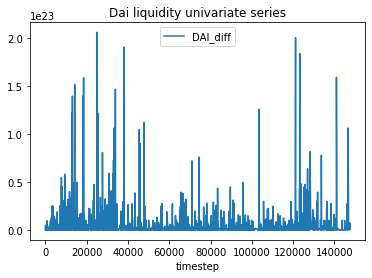

In [5]:
# liquidity series
liquidity_uniswap_events['DAI_balance'] = liquidity_uniswap_events['DAI_balance'].astype(float)
liquidity_uniswap_events['DAI_diff'] = abs(liquidity_uniswap_events['DAI_balance'].diff())
liquidity_uniswap_events['DAI_diff'].fillna(0,inplace=True)
liquidity_uniswap_events = liquidity_uniswap_events.query('DAI_diff > 0') 
liquidity_uniswap_events.plot(x='timestep',y='DAI_diff',title='Dai liquidity univariate series')

Text(0.5, 1.0, 'Histogram of Liquidity IID Samples')

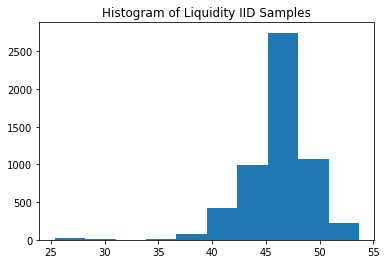

In [6]:
plt.hist(liquidity_uniswap_events['DAI_diff'].apply(np.log))
plt.title('Histogram of Liquidity IID Samples')

<AxesSubplot:title={'center':'Dai Buy/Sell Univariate Series'}, xlabel='timestep'>

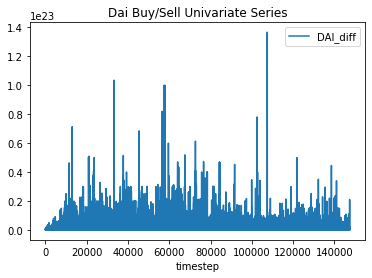

In [7]:
# buy/sell series
buy_sell_uniswap_events['DAI_balance'] = buy_sell_uniswap_events['DAI_balance'].astype(float)
buy_sell_uniswap_events['DAI_diff'] = abs(buy_sell_uniswap_events['DAI_balance'].diff())
buy_sell_uniswap_events['DAI_diff'].fillna(0,inplace=True)
buy_sell_uniswap_events = buy_sell_uniswap_events.query('DAI_diff > 0') 
buy_sell_uniswap_events.plot(x='timestep',y='DAI_diff',title='Dai Buy/Sell Univariate Series')

Text(0.5, 1.0, 'Histogram of Buy/Sell IID Samples')

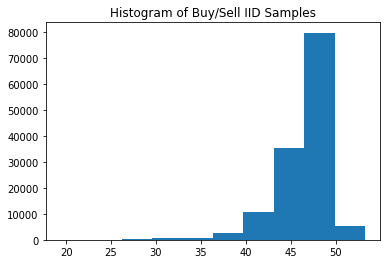

In [8]:
plt.hist(buy_sell_uniswap_events['DAI_diff'].apply(np.log))
plt.title('Histogram of Buy/Sell IID Samples')

## Distribution fitting

In [9]:
distribution, pvalue, params = get_best_distribution(liquidity_uniswap_events['DAI_diff'].apply(np.log).values)

/home/aclarkdata/repos/reflexer/venv/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2429: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


p value for alpha = 1.9846077928455934e-78
p value for gamma = 5.984630555350374e-66
p value for norm = 2.0790043873796766e-52
p value for exponweib = 7.875604567765168e-44
p value for weibull_max = 0.0
p value for weibull_min = 3.1716953793922973e-46
p value for pareto = 0.0
p value for genextreme = 0.0
Best fitting distribution: exponweib
Best p value: 7.875604567765168e-44
Parameters for the best fit: (2.574544903613731, 5.9403571180871175, 20.47915598285659, 24.236675532297106)


/home/aclarkdata/repos/reflexer/venv/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:2666: RuntimeWarning: invalid value encountered in subtract
  -pex2+logpex2-logex2)


In [10]:
# fit liquidity distribution
fit_shape_liquidity, fit_loc_liquidity, fit_scale_liquidity =st.alpha.fit(liquidity_uniswap_events['DAI_diff'].apply(np.log).values)


In [11]:
timesteps = 24 * 365 # 24 hours a day * 365 days a year 
timesteps

8760

Text(0.5, 1.0, 'Hisogram of Liquidity IID Samples')

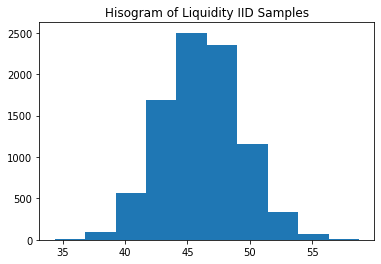

In [12]:
liquidity = st.alpha.rvs(fit_shape_liquidity, loc=fit_loc_liquidity, scale=fit_scale_liquidity, size=timesteps)
plt.hist(liquidity)
plt.title('Hisogram of Liquidity IID Samples')

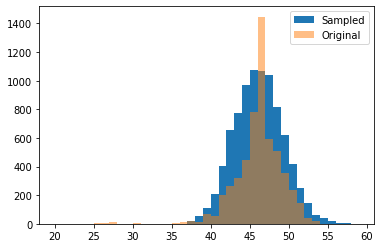

In [13]:
plt.hist(liquidity,bins=np.arange(20, 60),label='Sampled')
plt.hist(liquidity_uniswap_events['DAI_diff'].apply(np.log),alpha=0.5,bins=np.arange(20, 60),label='Original')
plt.legend()

In [14]:
hist,bins = np.histogram(liquidity,bins=50)
hist_original, bins = np.histogram(liquidity_uniswap_events['DAI_diff'].apply(np.log),bins=50) 

In [15]:

kl_divergence(hist,hist_original)

<ipython-input-2-cc37e35da16f>:28: RuntimeWarning: invalid value encountered in long_scalars
  return sum(p[i] * np.log2(p[i]/q[i]) for i in range(len(p)))
<ipython-input-2-cc37e35da16f>:28: RuntimeWarning: divide by zero encountered in long_scalars
  return sum(p[i] * np.log2(p[i]/q[i]) for i in range(len(p)))
<ipython-input-2-cc37e35da16f>:28: RuntimeWarning: divide by zero encountered in log2
  return sum(p[i] * np.log2(p[i]/q[i]) for i in range(len(p)))
<ipython-input-2-cc37e35da16f>:28: RuntimeWarning: invalid value encountered in multiply
  return sum(p[i] * np.log2(p[i]/q[i]) for i in range(len(p)))


nan

Text(0.5, 1.0, 'Time Series of Liquidity IID Samples')

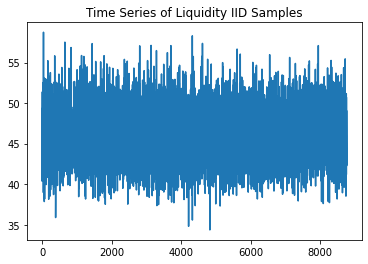

In [16]:
plt.plot(liquidity)
plt.title('Time Series of Liquidity IID Samples')

In [17]:
liquidity_samples = pd.DataFrame(np.exp(liquidity),columns=['Liquidity_Samples'])
liquidity_samples.to_csv('data/liquidity_samples.csv')

In [18]:
# fit buy/sell series distribution
distribution, pvalue, params = get_best_distribution(buy_sell_uniswap_events['DAI_diff'].apply(np.log).values)


/home/aclarkdata/repos/reflexer/venv/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2429: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


p value for alpha = 0.0
p value for gamma = 0.0
p value for norm = 0.0
p value for exponweib = 0.0
p value for weibull_max = 0.0
p value for weibull_min = 7.371315514163322e-216
p value for pareto = 0.0
p value for genextreme = 0.0
Best fitting distribution: weibull_min
Best p value: 7.371315514163322e-216
Parameters for the best fit: (176159.39129719994, -345664.41817406507, 345712.16799286334)


In [19]:
fit_shape_buy_sell, fit_loc_buy_sell, fit_scale_buy_sell = st.alpha.fit(buy_sell_uniswap_events['DAI_diff'].apply(np.log).values)

Text(0.5, 1.0, 'Histogram of Buy Sell IID Samples')

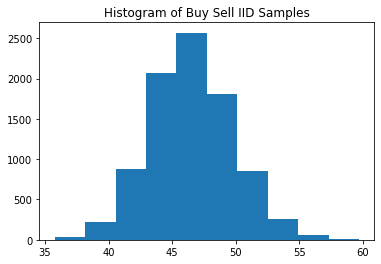

In [20]:
buy_sell = st.alpha.rvs(fit_shape_buy_sell, loc=fit_loc_buy_sell, scale=fit_scale_buy_sell, size=timesteps)

plt.hist(buy_sell)
plt.title('Histogram of Buy Sell IID Samples')

Text(0.5, 1.0, 'Time Series of Buy Sell IID Samples')

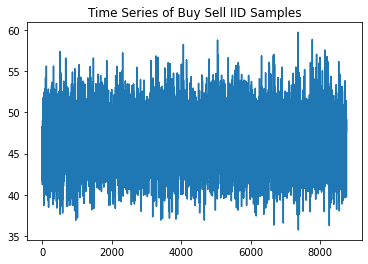

In [21]:
plt.plot(buy_sell)
plt.title('Time Series of Buy Sell IID Samples')

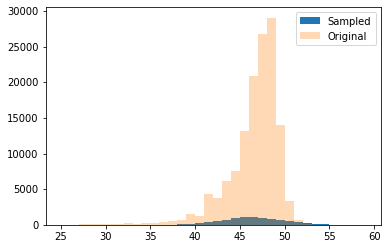

In [22]:
plt.hist(buy_sell,bins=np.arange(25, 60),label='Sampled')
plt.hist(buy_sell_uniswap_events['DAI_diff'].apply(np.log),alpha=0.3,bins=np.arange(25, 60),label='Original')
plt.legend()

In [23]:
buy_sell_samples = pd.DataFrame(np.exp(buy_sell),columns=['Buy_Sell_Samples'])
buy_sell_samples.to_csv('data/buy_sell.csv')

## Implementation information
Below is an example of how to integrate these univariate time series datasets into the exogenous process section of a cadCAD model, assuming each timestep is an hour.

```
# exogenousProcesses.py

# import libraries
import pandas as pd

# import data
liquidity_samples = pd.read_csv('data/liquidity_samples.csv')
buy_sell_samples = pd.read_csv('data/buy_sell.csv')

# mechanisms
def liquidity_exogenous_process(params, step, sL, s, _input):
    y = 'liquidity'
    timestep = s['timestep'] 
    x = liquidity_samples.Liquidity_Samples.values[timestep]
    return (y, x)
    
def buy_sell_exogenous_process(params, step, sL, s, _input):
    y = 'buy_sell'
    timestep = s['timestep'] 
    x = buy_sell_samples.Buy_Sell_Samples.values[timestep]
    return (y, x)
    
```